## Objective: Same scenario debugging

The purpose of this notebook is to align `gpudrive` with `waymax` so that we can reliably use a pre-trained VBD model.

**Notebook sections**

- Configurations
- Load VDB model
- **Waymax** video and distributions
    - Initialize waymax env with debugging scene
    
    - Make video with log-playback trajectories
    - Make video with VBD trajs
    - Feature distributions
- **GPUDrive** video and distributions
    - Initialize GPUDrive env with debugging scene
    - Make video with log-playback trajectories
    - Make video with VBD trajs
    - Feature distributions

----

**Scenario hex id**: `ab2a72c63f8fd589`

### Dependencies

In [1]:
%%capture
import waymax
import numpy as np
import math
import mediapy
from tqdm import tqdm
import dataclasses
import os
from pathlib import Path
import pickle
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from waymax import config as _config
from waymax import dataloader, datatypes, visualization, dynamics
from waymax.datatypes.simulator_state import SimulatorState
from waymax.config import EnvironmentConfig, ObjectType

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

# VBD dependencies
from vbd.sim_agent.waymax_env import WaymaxEnvironment
from vbd.data.dataset import WaymaxTestDataset
from vbd.waymax_visualization.plotting import plot_state
from vbd.sim_agent.sim_actor import VBDTest, sample_to_action
from vbd.model.utils import set_seed

# GPUDrive dependencies
from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig, SelectionDiscipline
from pygpudrive.env.env_torch import GPUDriveTorchEnv

# Plotting
sns.set("notebook")
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
#%config InlineBackend.figure_format = 'svg'

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

2024-10-08 06:52:11.031980: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 06:52:11.038054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 06:52:11.044622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 06:52:11.046603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 06:52:11.052408: I tensorflow/core/platform/cpu_feature_guar

### Helper functions

In [3]:
def plot_batch_distributions(batch, timestep, title, dist_type='hist'):

    num_keys = len(batch.keys())
    num_cols = 4
    num_rows = math.ceil(num_keys / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(11, num_rows * 2))
    fig.suptitle(f"{title} | Scenario id: {SCENARIO_ID} | t = {timestep}", y=1.02)
    axes = axes.flatten()

    for i, key in enumerate(batch.keys()):
        data = batch[key].flatten()
        
        if dist_type == 'hist':
            axes[i].hist(batch[key].flatten(), bins=30)
        elif dist_type == 'box_plot':
            
            sns.boxplot(data=data, ax=axes[i], width=0.3)
            # Add a strip plot to visualize individual data points
            sns.stripplot(data=data, ax=axes[i], color='k', size=3, jitter=True)
        
        max_value = data.max()
        min_value = data.min()
        axes[i].set_title(f"{key}: Min={min_value:.2f}, Max={max_value:.2f}", fontsize=8)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()
    
    # Save as pdf
    fig.savefig(f'{title}_{SCENARIO_ID}_t{timestep}_{dist_type}.png', format='png', bbox_inches='tight')

### Configurations

In [5]:
DATA_DIR = 'data/processed' # Base data path
CKPT_DIR = 'data/checkpoints' # Base checkpoint path

SCENARIO_ID = 'ab2a72c63f8fd589' # Debugging scenario we use 
CKPT_PATH = 'vbd/weights/epoch=18.ckpt'

FPS = 20
INIT_STEPS = 11 # Warmup period
MAX_CONTROLLED_OBJECTS = 32

### Load pre-trained VBD model

In [12]:
# Load model
model = VBDTest.load_from_checkpoint(CKPT_PATH, torch.device('cpu'))
_ = model.cuda()
_ = model.eval();

# Model settings
replan_freq=80 # Roll out every X steps 80 means openloop
model.early_stop=0 # Stop Diffusion Early From 100 to X
model.skip = 1 # Skip Alpha 
model.reward_func = None

# Ensure reproducability
set_seed(5)

### **Waymax** video and distributions

#### Initialize waymax env with debugging scene

In [13]:
env_config = EnvironmentConfig(
    controlled_object=ObjectType.VALID,
    allow_new_objects_after_warmup=False,
    init_steps=INIT_STEPS+1,
    max_num_objects=MAX_CONTROLLED_OBJECTS,
)

waymax_env = WaymaxEnvironment(
    dynamics_model=dynamics.StateDynamics(),
    config=env_config,
    log_replay = True,
)

scenario_path = os.path.join(DATA_DIR, SCENARIO_ID + '.pkl')
with open(f'{DATA_DIR}/waymax/scenario_{SCENARIO_ID}.pkl', 'rb') as f:
    scenario = pickle.load(f)
    
# Create "dataset" (need for utils)
dataset = WaymaxTestDataset(
    data_dir = 'data/processed/waymax', 
    anchor_path = 'vbd/data/cluster_64_center_dict.pkl',
    max_object=MAX_CONTROLLED_OBJECTS,
)

Found 1 scenarios


#### Make video with log-playback trajectories

- As a sanity check, we first look at the replayed human trajectories 
- Note that **only 3 agents** are actually moving, the rest of the vehicles are static.

""

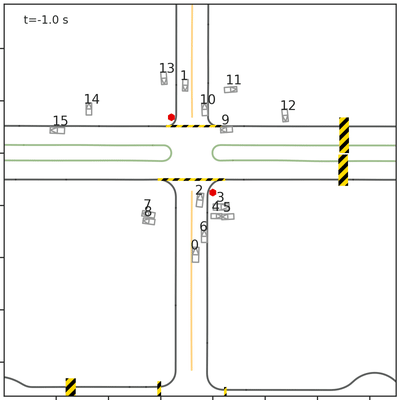

In [14]:
scenario.sim_trajectory = scenario.log_trajectory

log_playback_imgs = []
for t in range(scenario.remaining_timesteps):
  scenario.timestep = t
  log_playback_imgs.append(plot_state(scenario))

mediapy.show_video(log_playback_imgs, codec='gif', fps=FPS)

#### Make video with VBD trajectories (unguided)

- Let's see what kind of trajectories VBD generates for this scenario



In [15]:
# Reset 
init_state = waymax_env.reset(scenario)

# Process the scenario
current_state = init_state
sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=False
)
is_controlled = sample['agents_interested']>0
selected_agents = sample['agents_id'][is_controlled]

print(f'controlling agents: {selected_agents}')

state_logs = [current_state]

for i in range(current_state.remaining_timesteps):
    t = i % replan_freq
    if t == 0:
        print("Replan at ", current_state.timestep)
        sample = dataset.process_scenario(
          current_state, 
          current_index = current_state.timestep,
          use_log=False,
          selected_agents=selected_agents, # override the agent selection by distance to the ego
        )
        batch = dataset.__collate_fn__([sample])
        pred = model.sample_denoiser(batch)
        traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

    # Get action
    action_sample = traj_pred[:, t, :]
    action = sample_to_action(
      action_sample, 
      is_controlled, 
      agents_id=selected_agents, 
      max_num_objects=MAX_CONTROLLED_OBJECTS
    )
    # Step the simulator
    current_state = waymax_env.step_sim_agent(current_state, [action])
    state_logs.append(current_state)

vbd_waymax_imgs = [plot_state(state) for state in state_logs]

controlling agents: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Replan at  11


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 32.65it/s]


---

> ### Observations from watching a couple of VBD-generated traj videos:

- **Pro**: Generated trajectories are smooth and human-like
- **Pro**: Vehicles do not collide with road edges
- **Limitation**: Trajectories often "drive through" other vehicles (what we can improve with RL).

---

""

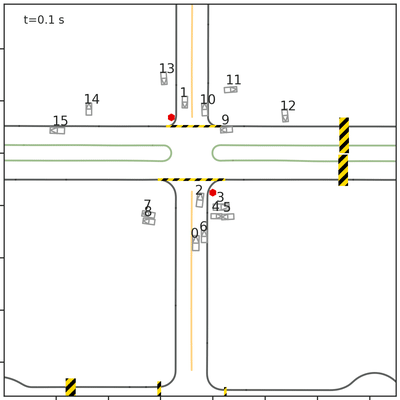

In [16]:
mediapy.show_video(vbd_waymax_imgs, codec='gif', fps=FPS)

#### Distributions of input features


In [18]:
init_state = waymax_env.reset(scenario)

print(f'Steps remaining: {init_state.remaining_timesteps}')

waymax_vbd_sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=False
)

# Save dictionary for further inspection
with open(f'waymax_vbd_sample_{SCENARIO_ID}.pkl', 'wb') as f:
    pickle.dump(waymax_vbd_sample, f)

Steps remaining: 79


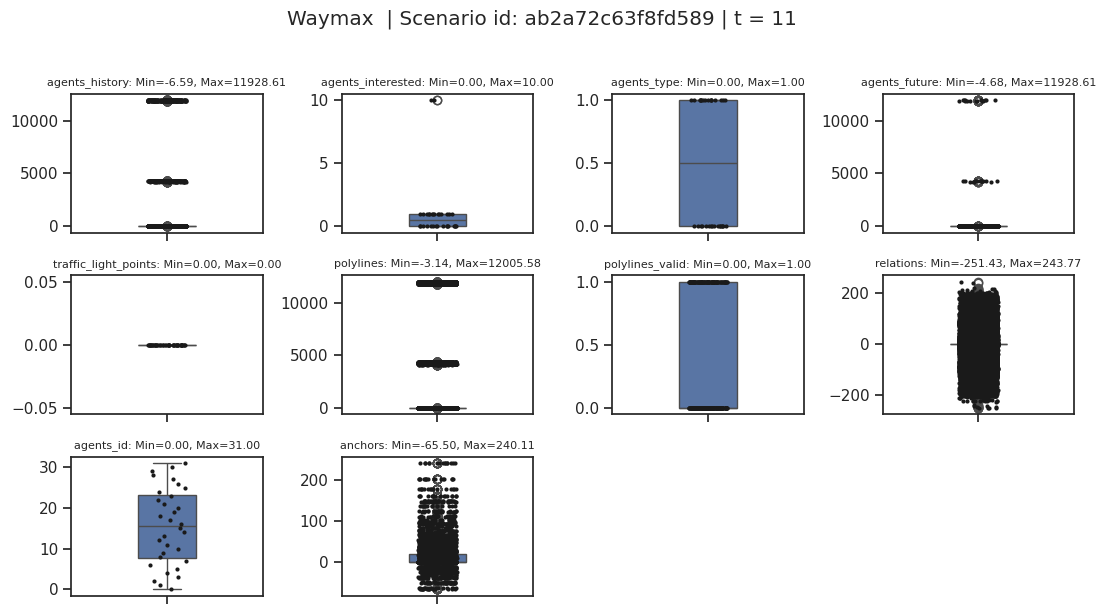

In [19]:
plot_batch_distributions(waymax_vbd_sample, title='Waymax ', timestep=int(init_state.timestep), dist_type='box_plot')

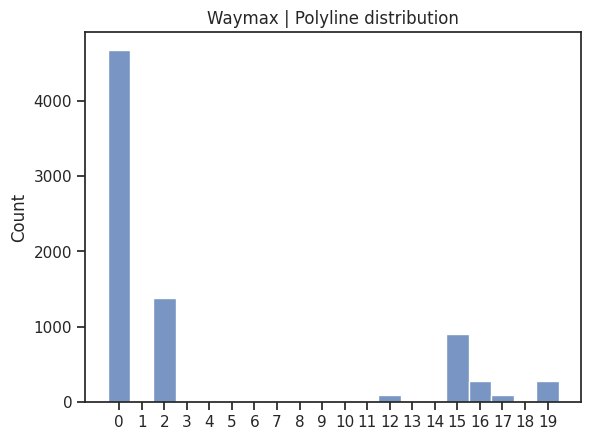

In [20]:
sns.histplot(waymax_vbd_sample["polylines"][:, :, -1].flatten(), bins=20, discrete=True)
plt.title("Waymax | Polyline distribution")
plt.xticks(range(20));

### **GPUDrive** video and distributions

#### Initialize GPUDrive env with debugging scene

In [27]:
env_config = EnvConfig(
    init_steps=INIT_STEPS, # Warmup period
    enable_vbd=True, # Use VBD
    dynamics_model="state", # Use state-based dynamics model
    dist_to_goal_threshold=1e-5, # Trick to make sure the agents don't disappear when they reach the goal
    collision_behavior="ignore", # Ignore collisions
)

# Make env
gpudrive_env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=SceneConfig(path="data/debug", num_scenes=1),
    render_config=RenderConfig(draw_obj_idx=True, render_init=True, resolution=(650, 650)),
    max_cont_agents=MAX_CONTROLLED_OBJECTS, # Maximum number of agents to control per scene
    device="cpu",
)


--- Ratio unique scenes / number of worls =         1 / 1 ---



#### Make video with log-playback trajectories

- As a sanity check, we first look at the replayed human trajectories 
- Note that only 3 agents are actually moving, the rest of the vehicles are static

In [31]:
init_state = gpudrive_env.reset()

log_playback_traj = gpudrive_env.get_expert_actions()

gpudrive_log_playback_frames = []

for t in range(env_config.episode_len-(INIT_STEPS+1)):
     
    # Step
    gpudrive_env.step_dynamics(log_playback_traj[:, :, t, :]) 

    # Render: rotate 180 degrees because waymax frames are flipped
    gpudrive_log_playback_frames.append(np.rot90(gpudrive_env.render(), k=2))

---

> **Note: Passes sanity check. ✅** This is exactly the same as the one in Waymax (we control n=3 vehicles + same trajs). 

---

GPUDrive with log-playback trajectories

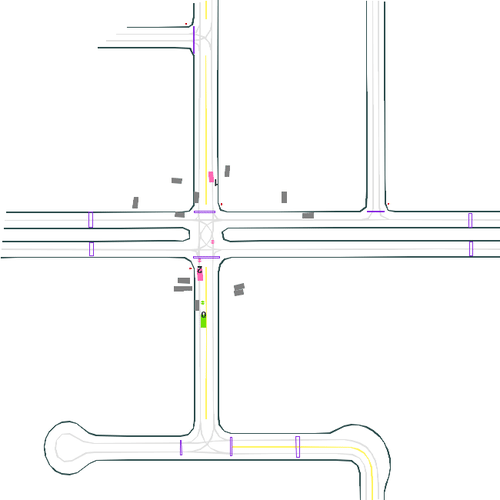

In [33]:
mediapy.show_video(gpudrive_log_playback_frames, codec='gif', title='GPUDrive with log-playback trajectories', width=500)

#### Make video with VBD trajectories (unguided)

In [34]:
# Reset env with warmup period 
init_state = gpudrive_env.reset()

selected_agents = torch.nonzero(gpudrive_env.cont_agent_mask[0, :]).flatten().tolist()

print(f"Controlling {len(selected_agents)} agents: {selected_agents}")

# Obtain all info for diffusion model (warmup)
gpudrive_sample_batch = gpudrive_env.warmup_trajectory

# Obtain predicted trajectories
pred = model.sample_denoiser(gpudrive_sample_batch)#, x_t=x_t)
vbd_traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

is_controlled = gpudrive_sample_batch['agents_interested'] > 0

Controlling 3 agents: [6, 10, 15]


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 30.35it/s]


In [35]:
# Our sim expects a 10D action with the state dynamics model
# (x, y, z, yaw, vel x, vel y, vel z, ang_vel_x, ang_vel_y, ang_vel_z)
# (0, 1, 2, 3,     4,   5,    6,        7,         8,         9)

pred_trajs = torch.zeros((MAX_CONTROLLED_OBJECTS, env_config.episode_len-INIT_STEPS, 10))
pred_trajs[:, :, 0:2] = torch.Tensor(vbd_traj_pred[:, :, 0:2]) # pos x, y
pred_trajs[:, :, 3] = torch.Tensor(vbd_traj_pred[:, :, 2]) # yaw 
pred_trajs[:, :, 4:6] = torch.Tensor(vbd_traj_pred[:, :, 3:5]) # vel x, y
pred_trajs = pred_trajs.unsqueeze(0)

print(f'Rolling out from t = {gpudrive_env.step_in_episode} to t = {env_config.episode_len}')

frames = []

# Step
for t in range(env_config.episode_len-(INIT_STEPS+1)):
    
    gpudrive_env.step_dynamics(pred_trajs[:, :, t, :])

    frames.append(np.rot90(gpudrive_env.render(), k=2))

Rolling out from t = 11 to t = 91


---

> ### Observations:
- Good: Trajectories look smooth/human-like similar to those in Waymax
- Bug: Vehicles drive through road edges (why?)
- Bug: One vehicle (#id 2 here) does not move but only rotates slightly (why?)
---

GPUDrive with VBD-trajs

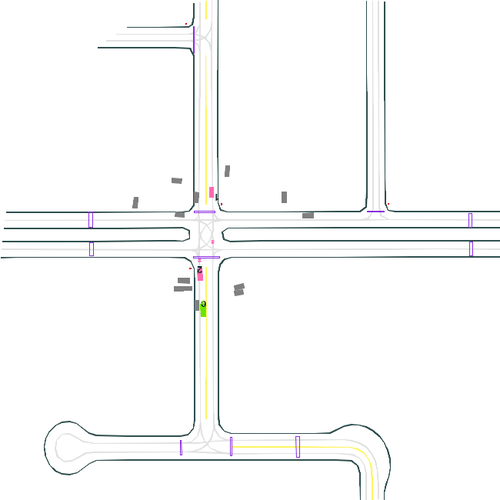

In [50]:
mediapy.show_video(frames, codec='gif', title='GPUDrive with VBD-trajs', width=500, fps=FPS)

#### Distributions of input features

In [51]:
def to_numpy(d):return {k: v.cpu().numpy() for k, v in d.items()}

gpudrive_sample_batch_np = to_numpy(gpudrive_sample_batch)

# Save as pickle 
with open(f'gpudrive_vbd_sample_{SCENARIO_ID}.pkl', 'wb') as f:
    pickle.dump(gpudrive_sample_batch_np, f)

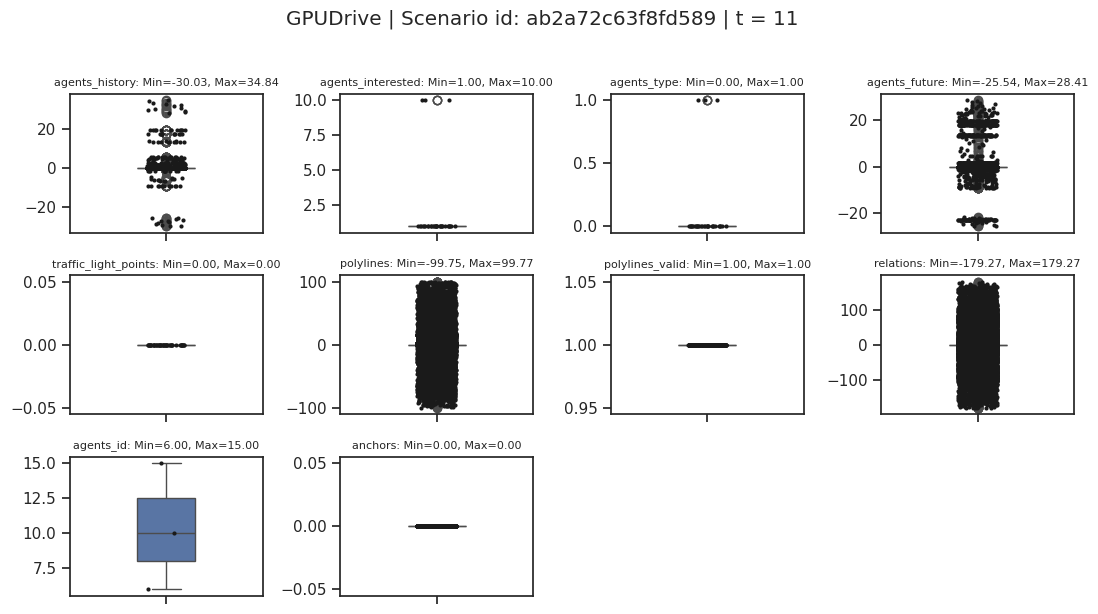

In [52]:
plot_batch_distributions(gpudrive_sample_batch_np, title='GPUDrive', timestep=INIT_STEPS, dist_type='box_plot')

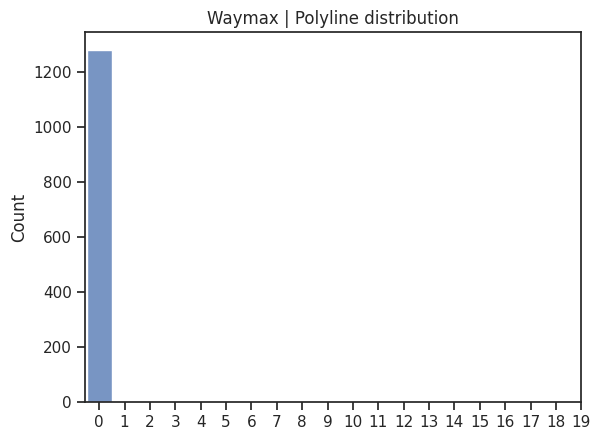

In [53]:
sns.histplot(gpudrive_sample_batch_np["polylines"][:, :, -1].flatten(), bins=20, discrete=True)
plt.title("Waymax | Polyline distribution")
plt.xticks(range(20));